# Radio ML Classification - ANN Approach

Solution to the RadioML classification challenge using ANNs.

In [1]:
# Loading Data

pathToDataset = "C:/Users/aksha/Documents/Jupyter Notebooks/radioml-classification/Datasets/Standard/RML2016.10a_dict.pkl"

# Extract the pickle file
import pickle
import numpy as np
Xd = pickle.load(open(pathToDataset,'rb'),encoding="bytes")
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

# Description of Data

The dataset has the size 220,000×2×128, which means that there are 220,000 entries, each consisting of an array of size 2 × 128. Each array represents the samples of about 128 µs of a received waveform sampled with approximately 106 samples/second, and it contains between 8 and 16 modulation symbols. Since the samples of the signal waveforms are complex-valued, they have been stored as real and imaginary parts, and therefore we have arrays of size 2 × 128 in the data set.

That is, each row is essentially, **a + ib**.

The labels of the downloaded dataset contain two parameters: the modulation technique used (one of [’8PSK’, ’AM-DSB’, ’AM-SSB’, ’BPSK’,’CPFSK’, ’GFSK’, ’PAM4’, ’QAM16’, ’QAM64’, ’QPSK’, ’WBFM’], so 11 possible modulation techniques), and the signal-to noise ratio (SNR) value (one of [−20, −18, −16, −14, −12, −10, −8, −6, −4, −2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18], so 20 possible SNR values). The SNR is a measure for the quality of the communication channel. The higher the SNR, the less “noisy” is the channel.

Each item of the list is essentially like **(b'Modulation Type',SNR Value)**

In [10]:
# Import Necessary Packages
%matplotlib inline
import os
import random
import tensorflow.keras.utils
import tensorflow.keras.models as models
from tensorflow.keras.layers import Reshape,Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, BatchNormalization, LayerNormalization
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import *
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras
import numpy as np
import scipy.stats as sp

# Data Processing

The goal of this stage is to split data into Training, Validation and Testing data and then process the available data and transform (if needed) it into relevant inputs to be fed into the ANN.

1. Split Dataset into Training, Validation and Testing Data : 110,000 samples for training and validation and 110,000 samples for testing.

2. Write a function to process data and extract features which are fed into the ANN. (Refer ANN-1 Paper for Features)

In [3]:
#  into training and test sets of the form we can train/test on 
np.random.seed(777)

index = np.arange(0,220000)
random.shuffle(index)

trainIdx = index[0:110000]
testIdx = index[110000:220000]

trainX = X[trainIdx]


testX = X[testIdx]

In [4]:
# One Hot Encode Labels
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(np.asarray(lbl)[:,0])
print(lb.classes_)
lbl_encoded=lb.transform(np.asarray(lbl)[:,0])
y_train=lbl_encoded[trainIdx]
y_test=lbl_encoded[testIdx]

[b'8PSK' b'AM-DSB' b'AM-SSB' b'BPSK' b'CPFSK' b'GFSK' b'PAM4' b'QAM16'
 b'QAM64' b'QPSK' b'WBFM']


In [5]:
# Helper Methods

# Normalize By Mean
def normalizeMean(data):
    meanData = np.mean(data,axis=2)
    
    dataReal = data[:,0,:]
    meanReal = (np.array([meanData[:,0]])).T
    normalReal = dataReal/meanReal
    
    dataImag = data[:,1,:]
    meanImag = (np.array([meanData[:,1]])).T
    normalImag = dataImag/meanImag
    
    return normalReal, normalImag

# Compute Instantaneous Amplitude (or Magnitude)
def instAmp(data):
    return np.linalg.norm(data,axis=1)

# Function for Raw Moment
def rawMoment(data,n):
    # Calculate the nth Raw Moment of The Data
    dataRaised = np.power(data,n)
    nthMoment = np.array([np.mean(dataRaised,axis=1)])
    
    return nthMoment.T

In [6]:
# Feature Extraction Methods

test = np.array([[[1,2],[3,4]],[[5,6],[7,8]],[[9,10],[11,12]]]) # Test Data

# Feature 1: Ratio of Real and Complex Power

def betaRatio(data):
    sumOfSquares = np.sum(np.square(data),axis=2)
    beta = sumOfSquares[:,1]/sumOfSquares[:,0] # Q / I
    beta = np.array([beta])
    beta = beta.T
    return beta

# Feature 2: Standard Deviation of Direct Instantaneous Phase [IMP: Consider Noise Threshold]

def sigmaDP(data,n):
    # n is a flag for normalization
    # n = 1 : Normalize
    
    if(n==0):
        dataReal = data[:,0,:]
        dataImag = data[:,1,:]
    
    if(n==1):
        dataReal, dataImag = normalizeMean(data)
    
    # Perform I / R
    tanArg = dataImag/dataReal
    
    # ArcTan | Instantaneous Phase
    phase = np.arctan(tanArg)
    
    # Standard Deviation of Phase
    sigDP = np.array([np.std(phase,axis=1)])
    
    return phase, sigDP.T # Also Returns Phase for Use Later

# Feature 3: Standard Deviation of Absolute Value of Non Linear Component of Instantaneous Phase
def sigmaAP(data,n):
    # n is a flag for normalization
    # n = 1 : Normalize
    
    if(n==0):
        dataReal = data[:,0,:]
        dataImag = data[:,1,:]
    
    if(n==1):
        dataReal, dataImag = normalizeMean(data)
    
    # Perform I / R
    tanArg = dataImag/dataReal
    
    # ArcTan | Instantaneous Phase
    phase = np.arctan(tanArg)
    phase = np.abs(phase)
    
    # Standard Deviation of Phase
    sigAP = np.array([np.std(phase,axis=1)])
    
    return sigAP.T

# Feature 4: Standard Deviation of Absolute Value of Normalized Instantaneous Amplitude

# Absolute of Magnitude Basically
    
def sigmaAA(data):
    instAmplitude = instAmp(data)
    
    # Sepcial Normalization
    meanInstAmplitude = (np.array([np.mean(instAmplitude,axis=1)])).T
    normInstAmplitude = (instAmplitude / meanInstAmplitude) - 1 # This is acn
    
    # Find Absolute of acn
    normInstAmplitude = np.abs(normInstAmplitude)
    
    sigAA = np.array([np.std(normInstAmplitude,axis=1)])
    
    return sigAA.T

# Feature 5: Standard Deviation of Absolute Normalized Centered Instantaneous Frequency

# Less Accurate Estimate Using First Differences
def sigmaAF(phase):
    
    # Compute Instantaneous Frequency
    instFrequency = np.diff(phase) # Approximation of Derivative
    
    # Normalize and Center
    meanInstFrequency = (np.array([np.mean(instFrequency,axis=1)])).T
    normInstFrequency = (instFrequency / meanInstFrequency) - 1
    
    # Find Absolute
    normInstFrequency = np.abs(normInstFrequency)
    
    # Find Standard Deviation
    sigAF = np.array([np.std(normInstFrequency,axis=1)])
    
    return sigAF.T

# Feature 6: Standard Deviation of Absolute Value of Instantaneous Amplitude (Normalized w.r.t Variance)
def sigmaV(data):
    instAmplitude = instAmp(data)
    
    # Normalize w.r.t Variance
    varInstAmplitude = (np.array([np.var(instAmplitude,axis=1)])).T
    normInstAmplitude = np.sqrt(instAmplitude/varInstAmplitude) - 1
    
    # Find Absolute
    normInstAmplitude = np.abs(normInstAmplitude)
    
    # Find Standard Deviation
    sigV = np.array([np.std(normInstAmplitude,axis=1)])
    
    return sigV.T

# Feature 7: Mixed Order Moments [M(4,2) / M(2,1)]
def genV20(data):
    instAmplitude = instAmp(data)
    
    moment4 = rawMoment(instAmplitude,4)
    moment2 = rawMoment(instAmplitude,2) # Typo in Paper, Squared?
    
    return moment4 / moment2

# Feature 8: Mean of Signal Magnitude
def meanMag(data):
    instAmplitude = instAmp(data)
    meanMagnitude = np.array([np.mean(instAmplitude,axis=1)])
    
    return meanMagnitude.T

# Feature 9: Normalized Square Root of Sum of Amplitudes
def normRootSumAmp(data):
    instAmplitude = instAmp(data)
    sumAmpl = np.array([np.sum(instAmplitude,axis=1)]).T
    normRoot = np.sqrt(sumAmpl)/instAmplitude.shape[1]
    
    return normRoot

# Feature 10: Max PSD of Normalized Centered Amplitude
def maxPSD(data):
    instAmplitude = instAmp(data)
    # Compute DFT
    ampDFT = np.fft.fft(instAmplitude,axis=1)
    # Compute Magnitude Spectrum
    magAmpDFT = np.abs(ampDFT)
    # Power Spectrum
    powDFT = np.square(magAmpDFT)
    # Max Power
    maxPow = np.array([np.max(powDFT,axis=1)]).T
    
    return maxPow / maxPow.shape[0]

# Feature 11: Cumulant C20

# Feature 12: Cumulant C21
def getC21(data):
    instAmplitude = instAmp(data)
    cumulantC21 = rawMoment(instAmplitude,2)
    return cumulantC21

In [7]:
# Function to Generate Input vector
def createIPVector(data):
    beta = betaRatio(data)
    sigPhase, sigDp = sigmaDP(data,1)
    sigAp = sigmaAP(data,1)
    sigAa = sigmaAA(data)
    sigAF = sigmaAF(sigPhase)
    sigV = sigmaV(data)
    v20 = genV20(data)
    meanMagX = meanMag(data)
    X2 = normRootSumAmp(data)
    gammaMax = maxPSD(data)
    
    cumulantC21 = getC21(data)

    # Concat
    xtrainIP = np.concatenate((beta,sigDp,sigAp,sigAa,sigAF,sigV,v20,meanMagX,X2,gammaMax,cumulantC21),axis=1)
    return xtrainIP

# Generate Training and Testing Input Vectors
xtrainIP = createIPVector(trainX)
#xtrainIP = np.expand_dims(xtrainIP, axis=-1) # Important

xtestIP = createIPVector(testX)
#xtestIP = np.expand_dims(xtestIP, axis=-1) # Important

# Design Neural Network

In [31]:
# Network Parameters

# Structure
numInput = 11 # Number of Input Nodes
numHid1 = 1000 # Number of Nodes in the First Hidden Layer
numHid2 = 200 # Number of Nodes in the Second Hidden Layer
numHid3 = 40  # Number of Nodes in the Third Hidden Layer
numOutput = 11 # Number of Output Nodes

# Weight Initialization
weightInit = 'glorot_uniform' # Xavier Initialization

# Activation Functions
activationHidden = 'relu'
activationOutput = 'softmax'

# Loss Function
lossFunction = 'categorical_crossentropy'

# Learning Algorithm
#netOptimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=False)
netOptimizer = 'adam'

# Construct Network
model = models.Sequential()
#model.add(BatchNormalization(axis=-1,input_shape=(11,), name='Normalization_1'))
model.add(LayerNormalization(input_shape=(11,), name='Normalization'))
#model.add(Dense(numHid1, activation=activationHidden, kernel_initializer=weightInit, name='Hidden_Layer_1'))
model.add(Dense(numHid1, activation=activationHidden, name='Hidden_Layer_1'))
model.add(Dense(numHid2, activation=activationHidden, name='Hidden_Layer_2'))
model.add(Dense(numHid3, activation=activationHidden, name='Hidden_Layer_3'))
model.add(Dense(numOutput, activation=activationOutput, name='Output_Layer'))
model.compile(loss=lossFunction, optimizer=netOptimizer,metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Normalization (LayerNormaliz (None, 11)                22        
_________________________________________________________________
Hidden_Layer_1 (Dense)       (None, 1000)              12000     
_________________________________________________________________
Hidden_Layer_2 (Dense)       (None, 200)               200200    
_________________________________________________________________
Hidden_Layer_3 (Dense)       (None, 40)                8040      
_________________________________________________________________
Output_Layer (Dense)         (None, 11)                451       
Total params: 220,713
Trainable params: 220,713
Non-trainable params: 0
_________________________________________________________________


# Train Network

In [32]:
# Train Model
history = model.fit(xtrainIP, y_train, batch_size=1000, epochs=200, verbose=2, validation_split=0.1)

Train on 99000 samples, validate on 11000 samples
Epoch 1/200
99000/99000 - 1s - loss: 2.3263 - categorical_accuracy: 0.1256 - val_loss: 2.2757 - val_categorical_accuracy: 0.1449
Epoch 2/200
99000/99000 - 0s - loss: 2.2719 - categorical_accuracy: 0.1439 - val_loss: 2.2714 - val_categorical_accuracy: 0.1513
Epoch 3/200
99000/99000 - 0s - loss: 2.2598 - categorical_accuracy: 0.1508 - val_loss: 2.2472 - val_categorical_accuracy: 0.1585
Epoch 4/200
99000/99000 - 0s - loss: 2.2564 - categorical_accuracy: 0.1525 - val_loss: 2.2461 - val_categorical_accuracy: 0.1508
Epoch 5/200
99000/99000 - 0s - loss: 2.2486 - categorical_accuracy: 0.1548 - val_loss: 2.2343 - val_categorical_accuracy: 0.1624
Epoch 6/200
99000/99000 - 0s - loss: 2.2514 - categorical_accuracy: 0.1543 - val_loss: 2.2407 - val_categorical_accuracy: 0.1502
Epoch 7/200
99000/99000 - 0s - loss: 2.2353 - categorical_accuracy: 0.1616 - val_loss: 2.2400 - val_categorical_accuracy: 0.1591
Epoch 8/200
99000/99000 - 0s - loss: 2.2367 - c

Epoch 64/200
99000/99000 - 0s - loss: 2.1622 - categorical_accuracy: 0.1969 - val_loss: 2.1799 - val_categorical_accuracy: 0.1840
Epoch 65/200
99000/99000 - 0s - loss: 2.1846 - categorical_accuracy: 0.1869 - val_loss: 2.1659 - val_categorical_accuracy: 0.1915
Epoch 66/200
99000/99000 - 0s - loss: 2.1630 - categorical_accuracy: 0.1974 - val_loss: 2.1567 - val_categorical_accuracy: 0.1965
Epoch 67/200
99000/99000 - 0s - loss: 2.1642 - categorical_accuracy: 0.1959 - val_loss: 2.1505 - val_categorical_accuracy: 0.1948
Epoch 68/200
99000/99000 - 0s - loss: 2.1243 - categorical_accuracy: 0.2147 - val_loss: 2.1065 - val_categorical_accuracy: 0.2191
Epoch 69/200
99000/99000 - 0s - loss: 2.1762 - categorical_accuracy: 0.1911 - val_loss: 2.1499 - val_categorical_accuracy: 0.1994
Epoch 70/200
99000/99000 - 0s - loss: 2.1517 - categorical_accuracy: 0.2023 - val_loss: 2.1569 - val_categorical_accuracy: 0.1998
Epoch 71/200
99000/99000 - 0s - loss: 2.1299 - categorical_accuracy: 0.2141 - val_loss: 2.

Epoch 127/200
99000/99000 - 0s - loss: 2.0525 - categorical_accuracy: 0.2469 - val_loss: 2.0270 - val_categorical_accuracy: 0.2656
Epoch 128/200
99000/99000 - 0s - loss: 2.0396 - categorical_accuracy: 0.2545 - val_loss: 2.0806 - val_categorical_accuracy: 0.2405
Epoch 129/200
99000/99000 - 0s - loss: 2.0666 - categorical_accuracy: 0.2402 - val_loss: 2.0786 - val_categorical_accuracy: 0.2002
Epoch 130/200
99000/99000 - 0s - loss: 2.0473 - categorical_accuracy: 0.2464 - val_loss: 2.0279 - val_categorical_accuracy: 0.2686
Epoch 131/200
99000/99000 - 0s - loss: 2.0399 - categorical_accuracy: 0.2529 - val_loss: 2.0229 - val_categorical_accuracy: 0.2619
Epoch 132/200
99000/99000 - 0s - loss: 2.0219 - categorical_accuracy: 0.2584 - val_loss: 2.0345 - val_categorical_accuracy: 0.2435
Epoch 133/200
99000/99000 - 0s - loss: 2.0509 - categorical_accuracy: 0.2468 - val_loss: 2.0134 - val_categorical_accuracy: 0.2620
Epoch 134/200
99000/99000 - 0s - loss: 2.0177 - categorical_accuracy: 0.2619 - val_

Epoch 190/200
99000/99000 - 0s - loss: 2.0892 - categorical_accuracy: 0.2279 - val_loss: 1.9901 - val_categorical_accuracy: 0.2637
Epoch 191/200
99000/99000 - 0s - loss: 2.1514 - categorical_accuracy: 0.2035 - val_loss: 2.1536 - val_categorical_accuracy: 0.1988
Epoch 192/200
99000/99000 - 0s - loss: 2.1352 - categorical_accuracy: 0.2106 - val_loss: 2.1271 - val_categorical_accuracy: 0.2115
Epoch 193/200
99000/99000 - 0s - loss: 2.1313 - categorical_accuracy: 0.2109 - val_loss: 2.1257 - val_categorical_accuracy: 0.2139
Epoch 194/200
99000/99000 - 0s - loss: 2.1361 - categorical_accuracy: 0.2105 - val_loss: 2.1394 - val_categorical_accuracy: 0.2080
Epoch 195/200
99000/99000 - 0s - loss: 2.1296 - categorical_accuracy: 0.2140 - val_loss: 2.1301 - val_categorical_accuracy: 0.2135
Epoch 196/200
99000/99000 - 0s - loss: 2.1376 - categorical_accuracy: 0.2119 - val_loss: 2.1247 - val_categorical_accuracy: 0.2139
Epoch 197/200
99000/99000 - 0s - loss: 2.1159 - categorical_accuracy: 0.2211 - val_

# Test/Evaluate Network

In [33]:
model.evaluate(xtestIP,y_test)

110000/110000 [==============================] - 7s 63us/sample - loss: 2.0278 - categorical_accuracy: 0.2549


[2.027798629431291, 0.25486365]

# Visualaize Results

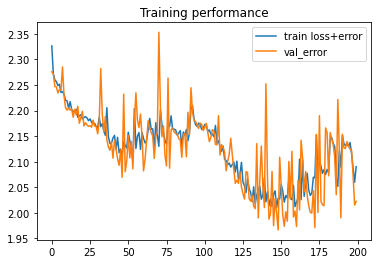

In [34]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [35]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

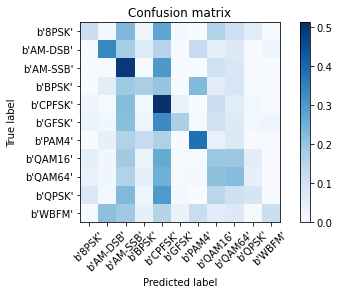

In [37]:
# Plot confusion matrix
test_Y_hat = model.predict(xtestIP, batch_size=1000)
conf = np.zeros([len(mods),len(mods)])
confnorm = np.zeros([len(mods),len(mods)])
for i in range(0,xtestIP.shape[0]):
    j = list(y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(mods)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=mods)

In [40]:
# Get the test accuracy for different SNRs
acc = {}
acc_array=[]

snr_array=np.asarray(lbl)[:,1]
lb_temp = preprocessing.LabelBinarizer()
lb_temp.fit(snr_array)
temp_array=lb_temp.classes_
snr_label_array = []


snr_label_array.append(temp_array[6])
snr_label_array.append(temp_array[4])
snr_label_array.append(temp_array[3])
snr_label_array.append(temp_array[2])
snr_label_array.append(temp_array[1])
snr_label_array.append(temp_array[0])
snr_label_array.append(temp_array[9])
snr_label_array.append(temp_array[8])
snr_label_array.append(temp_array[7])
snr_label_array.append(temp_array[5])
snr_label_array.append(temp_array[10])
snr_label_array.append(temp_array[16])
snr_label_array.append(temp_array[17])
snr_label_array.append(temp_array[18])
snr_label_array.append(temp_array[19])
snr_label_array.append(temp_array[11])
snr_label_array.append(temp_array[12])
snr_label_array.append(temp_array[13])
snr_label_array.append(temp_array[14])
snr_label_array.append(temp_array[15])


#print(snr_label_array)
y_test_snr=snr_array[testIdx]



for snr in snr_label_array:
    test_X_i = xtestIP[np.where(y_test_snr==snr)]
    test_Y_i = y_test[np.where(y_test_snr==snr)]
    
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(mods),len(mods)])
    confnorm = np.zeros([len(mods),len(mods)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(mods)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    
    #plt.figure()
    #plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor),"for SNR",snr)
    acc[snr] = 1.0*cor/(cor+ncor)
    acc_array.append(1.0*cor/(cor+ncor))

print("Random Guess Accuracy:",1/11)

Overall Accuracy:  0.08647090614303729 for SNR b'-20'
Overall Accuracy:  0.0943157132512672 for SNR b'-18'
Overall Accuracy:  0.08945744873888586 for SNR b'-16'
Overall Accuracy:  0.0888241718238078 for SNR b'-14'
Overall Accuracy:  0.09944354693950817 for SNR b'-12'
Overall Accuracy:  0.09873873873873874 for SNR b'-10'
Overall Accuracy:  0.13184257602862254 for SNR b'-8'
Overall Accuracy:  0.16800298340481074 for SNR b'-6'
Overall Accuracy:  0.21136158701532912 for SNR b'-4'
Overall Accuracy:  0.21961774251712946 for SNR b'-2'
Overall Accuracy:  0.24248496993987975 for SNR b'0'
Overall Accuracy:  0.2927456382001837 for SNR b'2'
Overall Accuracy:  0.3491464510332435 for SNR b'4'
Overall Accuracy:  0.40273163528977485 for SNR b'6'
Overall Accuracy:  0.3928375662342408 for SNR b'8'
Overall Accuracy:  0.4064360119047619 for SNR b'10'
Overall Accuracy:  0.43391430646332607 for SNR b'12'
Overall Accuracy:  0.43153901734104044 for SNR b'14'
Overall Accuracy:  0.43391791719399747 for SNR b'16

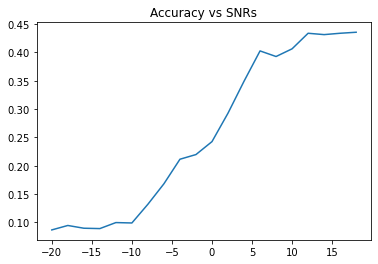

In [41]:
# Show loss curves 
plt.figure()
plt.title('Accuracy vs SNRs')
plt.plot(np.arange(-20,20,2), acc_array)